In [6]:
import os
from glob import glob
import numpy as np
import pandas as pd
import xarray as xr
import dask
import gev_utils as gevu
import sa_utils as sau
import plotting_utils as pu

from utils import city_list
from utils import roar_code_path as project_code_path
from utils import roar_data_path as project_data_path
# from utils import metric_ids, gard_gcms

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Set fonts
from matplotlib import font_manager
font_dirs = ["/storage/home/dcl5300/fonts"]

font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.5

In [61]:
ds = xr.open_dataset('/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/extreme_value/original_grid/max_pr/GARD-LENS_canesm5_r10i1p1f1_ssp370_2050-2100_stat_lmom.nc')

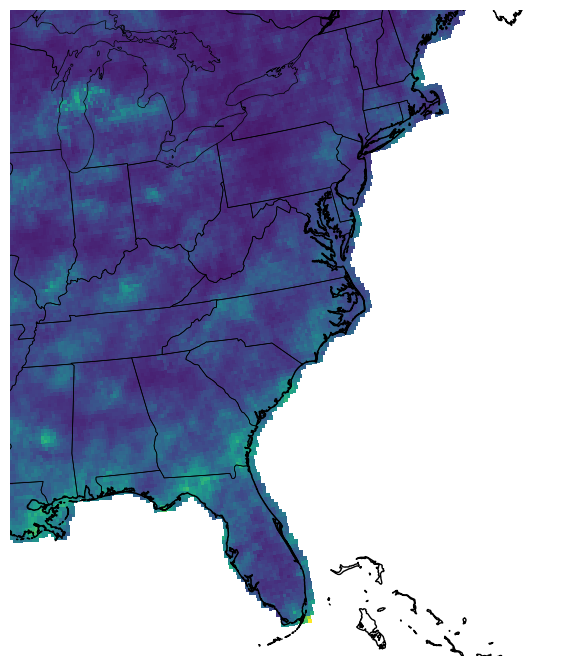

In [65]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.LambertConformal()), figsize=(6,8))

ds['100yr_return_level'].plot(ax=ax, transform=ccrs.PlateCarree(), cmap="viridis", add_colorbar=False)

# Tidy
ax.set_extent([-90, -70, 25, 45], ccrs.Geodetic())
ax.coastlines(resolution='10m')
ax.set_title('')
ax.add_feature(cfeature.STATES, edgecolor="black", linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.25)
ax.axis('off')
plt.tight_layout()
plt.savefig('../figs/map_example.png', dpi=600)

In [3]:
# Read UC results
file_path = f"{project_data_path}/results/max_pr_2050-2100_1950-2014_100rl_nearest.nc"
uc = xr.open_dataset(file_path)

In [159]:
city = 'nyc'
ds_plot = uc.sel(lat=city_list[city][0], lon=360+city_list[city][1], method='nearest')

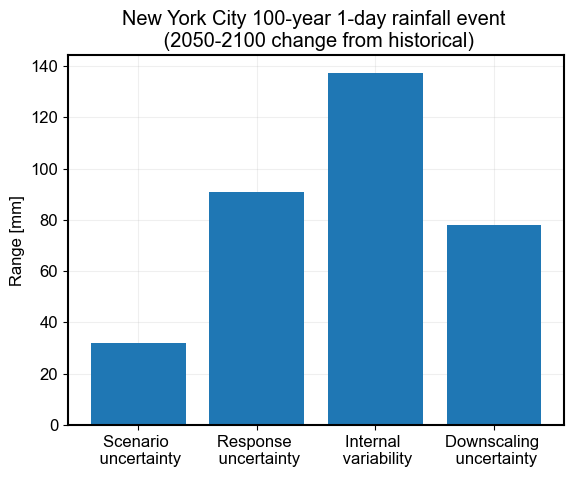

In [160]:
fig, ax = plt.subplots()
uc_vals = [#ds_plot['uc_range'],
           ds_plot['ssp_uc'],
           ds_plot['gcm_uc'],
           ds_plot['iv_uc'],
           ds_plot['dsc_uc']
          ]
uc_names = [#'Total \n uncertainty',
            'Scenario \n uncertainty',
            'Response \n uncertainty', 
            'Internal \n variability',
            'Downscaling \n uncertainty']

ax.bar(uc_names, uc_vals, zorder=2)
ax.set_ylabel('Range [mm]')
ax.set_title('New York City 100-year 1-day rainfall event \n (2050-2100 change from historical)')
ax.grid(alpha=0.2, zorder=3)
plt.savefig('../figs/nyc_change_uc_example.png', dpi=300)

In [79]:
# Read timeseries
df = pd.read_csv('/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/metrics/cities/nyc_max_pr.csv')

df_proj = df[(df['gcm'] == 'CanESM5') & (df['ssp'] == 'ssp370') & (df['ensemble'] == 'GARD-LENS') & (df['member'] == 'r1i1p1f1')]
df_hist = df[(df['gcm'] == 'CanESM5') & (df['ssp'] == 'historical') & (df['ensemble'] == 'GARD-LENS') & (df['member'] == 'r1i1p1f1')]

In [80]:
# Read RLs
df_rl = pd.read_csv('/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/extreme_value/cities/loca_grid/nyc_max_pr_2050-2100_1950-2014_100rl_nearest.csv')

In [81]:
import gev_utils as gevu

In [82]:
loc, scale, shape = gevu._fit_gev_1d(df_proj['pr'].to_numpy())
gevu.estimate_return_level(100, loc, scale, shape)

127.5128658048078

In [85]:
loc, scale, shape = gevu._fit_gev_1d(df_proj.query('time >= 2050 and time <= 2098')['pr'].to_numpy())
rl100_far_proj = gevu.estimate_return_level(100, loc, scale, shape)

loc, scale, shape = gevu._fit_gev_1d(df_proj.query('time <= 2050')['pr'].to_numpy())
rl100_mid_proj = gevu.estimate_return_level(100, loc, scale, shape)

# loc, scale, shape = gevu._fit_gev_1d(df_hist['pr'].to_numpy())
# rl100_hist = gevu.estimate_return_level(100, loc, scale, shape)

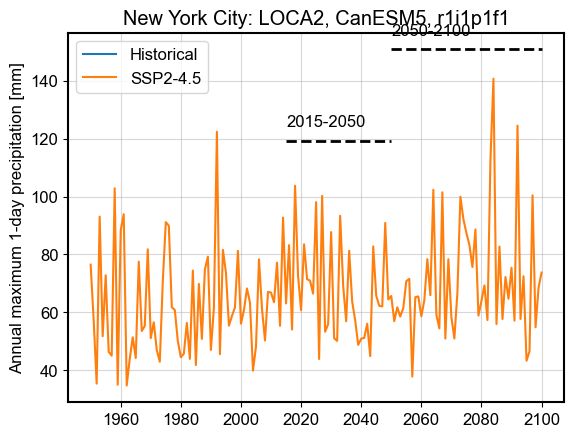

In [87]:
fig, ax = plt.subplots()

df_hist.plot(x='time', y='pr', ax=ax, label='Historical', color='C0')
# ax.hlines(rl100_hist, 1950, 2014, colors='black', ls='--', lw=2)
# ax.text(1949, rl100_hist + 5, '1950-2014 100-year event')

df_proj.plot(x='time', y='pr', ax=ax, label='SSP2-4.5', color='C1')

ax.hlines(rl100_mid_proj, 2015, 2050, colors='black', ls='--', lw=2)
ax.text(2015, rl100_mid_proj + 5, '2015-2050')

ax.hlines(rl100_far_proj, 2050, 2100, colors='black', ls='--', lw=2)
ax.text(2050, rl100_far_proj + 5, '2050-2100')

ax.set_xlabel('')
ax.set_ylabel('Annual maximum 1-day precipitation [mm]')
ax.grid(alpha=0.5)

ax.set_title('New York City: LOCA2, CanESM5, r1i1p1f1')
# ax.set_ylim([0,350])

plt.savefig('../figs/nyc_timeseries_example.png', dpi=400)

In [2]:
import numpy as np
import xarray as xr

def compute_percentile_multiple_datasets(datasets, variable, percentile):
    """
    Compute percentile across multiple xarray datasets without concatenating them.
    
    Parameters:
    datasets (list): List of xarray datasets
    variable (str): Name of the variable to compute percentile for
    percentile (float): Percentile to compute (0-100)
    
    Returns:
    float: Computed percentile value
    """
    # Get total number of elements
    total_elements = sum(ds[variable].size for ds in datasets)
    
    # Calculate target number of elements below the percentile
    target_count = (percentile / 100.0) * total_elements
    
    # Get sorted unique values across all datasets
    # Use Dataset.values to convert to numpy array for unique value computation
    all_unique = np.unique(np.concatenate([np.unique(ds[variable].values) for ds in datasets]))
    
    # Count elements less than or equal to each unique value
    cumulative_counts = np.zeros_like(all_unique, dtype=float)
    for i, value in enumerate(all_unique):
        count = sum((ds[variable].values <= value).sum() for ds in datasets)
        cumulative_counts[i] = count
    
    # Find the value where cumulative count exceeds target
    idx = np.searchsorted(cumulative_counts, target_count)
    if idx >= len(all_unique):
        return all_unique[-1]
    return all_unique[idx]

# Alternative approach using xarray's built-in quantile method
def compute_percentile_xarray_native(datasets, variable, percentile):
    """
    Compute percentile across multiple xarray datasets using xarray's native functionality.
    This method requires concatenating along a new dimension but is more accurate for
    continuous data.
    
    Parameters:
    datasets (list): List of xarray datasets
    variable (str): Name of the variable to compute percentile for
    percentile (float): Percentile to compute (0-100)
    
    Returns:
    float: Computed percentile value
    """
    # Create a new dimension for the datasets
    labeled_datasets = [ds[variable].expand_dims(dataset_id=[i]) 
                       for i, ds in enumerate(datasets)]
    
    # Concatenate along the new dimension
    combined = xr.concat(labeled_datasets, dim='dataset_id')
    
    # Compute the percentile using xarray's quantile method
    return float(combined.quantile(percentile/100, dim=combined.dims))

In [3]:
metric_id = 'max_tasmax'
regrid_method = 'nearest'
proj_slice = '2050-2100'
hist_slice = None

datasets = sau.read_all(
    metric_id,
    regrid_method,
    proj_slice,
    hist_slice,
)

In [4]:
ds0 = datasets[0].stack(z=('ensemble', 'member', 'ssp', 'gcm'))

In [8]:
ds1 = datasets[1].stack(z=('ensemble', 'member', 'ssp', 'gcm'))

In [9]:
ds2 = datasets[2].stack(z=('ensemble', 'member', 'ssp', 'gcm'))

In [10]:
del datasets

In [11]:
ds = xr.concat([ds2, ds1, ds0], dim='z')

In [13]:
ds_range = ds.max(dim='z') - ds.min(dim='z')

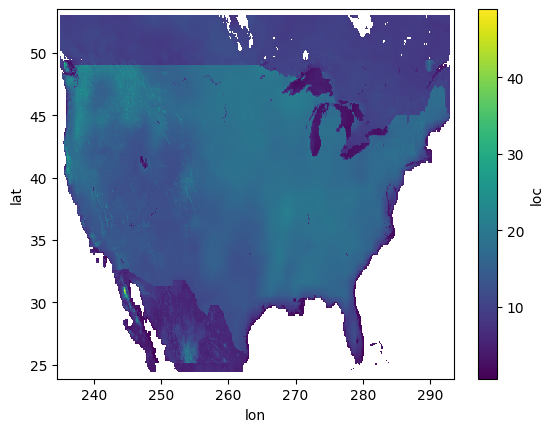

In [14]:
ds_range['loc'].plot()

In [16]:
ds_q99 = ds.quantile(0.995, dim='z') - ds.quantile(0.005, dim='z')

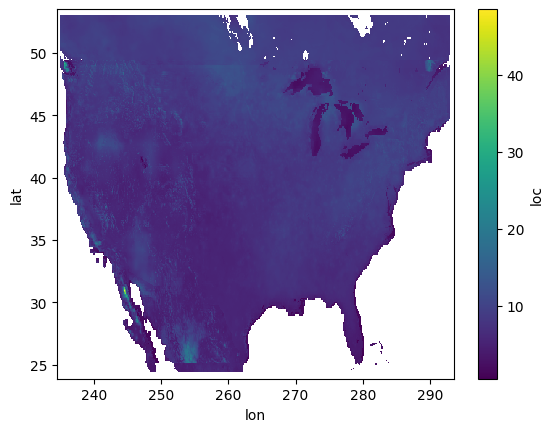

In [17]:
ds_q99['loc'].plot()

In [41]:
ds0.nbytes/1e9

20.87680052

In [43]:
datasets[0].nbytes/1e9

20.876515384